# XgBoost

Given the time constraints, I will quickly build a baseline model using XGBoost. This baseline model can then be used to understand feature importance with SHAP, which will help guide improvements in subsequent model iterations.

In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier

from fia.preprocess import preprocess_with_labelencoder
from fia.plots import PerformancePlotter
from fia.constants import (
    COL_BANK_MONTHS_COUNT,
    COL_PREV_ADDRESS_MONTHS_COUNT,
    COL_VELOCITY_4W,
    COL_DF_LABEL_FRAUD
)

/Users/maicolrodrigues/Documents/FIA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
FILENAME = "./data/Base.csv"
df = pd.read_csv(FILENAME)
df.shape

(1000000, 32)

## Remove the features that bring bias

From the Exploratory Data Analysis notebook, we identified features that do not contribute to improving the model, so we decided to remove these columns.

In [3]:
df = df.drop(columns=[
    COL_BANK_MONTHS_COUNT, 
    COL_PREV_ADDRESS_MONTHS_COUNT,
    COL_VELOCITY_4W
    ]
)

## Remove the empty rows

As we observed during the EDA, there is very little missing data. Although XGBoost can handle missing values, it is simpler to remove them as a starting point.

In [4]:
cols_missing = [
    'current_address_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'intended_balcon_amount'
]

df[cols_missing] = df[cols_missing].replace(-1, np.nan)

df= df.dropna()
df.shape

(993607, 29)

## Preprocessing

In [5]:
df_preprocessed, labelenocder, scaler = preprocess_with_labelencoder(df =df, col_label=COL_DF_LABEL_FRAUD)

In [6]:
X = df_preprocessed.drop(columns=COL_DF_LABEL_FRAUD, axis=1)
y = df_preprocessed[COL_DF_LABEL_FRAUD]

## Training and Testing

In [7]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns
X[categorical_features] = X[categorical_features].astype('category')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Calculate the scale_pos_weight parameter
negative_class_count = len(y_train[y_train == 0])
positive_class_count = len(y_train[y_train == 1])
scale_pos_weight = negative_class_count / positive_class_count


# Train an XGBoost model
model = XGBClassifier(
    # use_label_encoder=True, 
    # enable_categorical=True
    eval_metric='logloss', 
    scale_pos_weight= scale_pos_weight, 
)

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.8823
Precision: 0.0621
Recall: 0.6832
F1-Score: 0.1138
AUC-ROC: 0.8744


## Plots

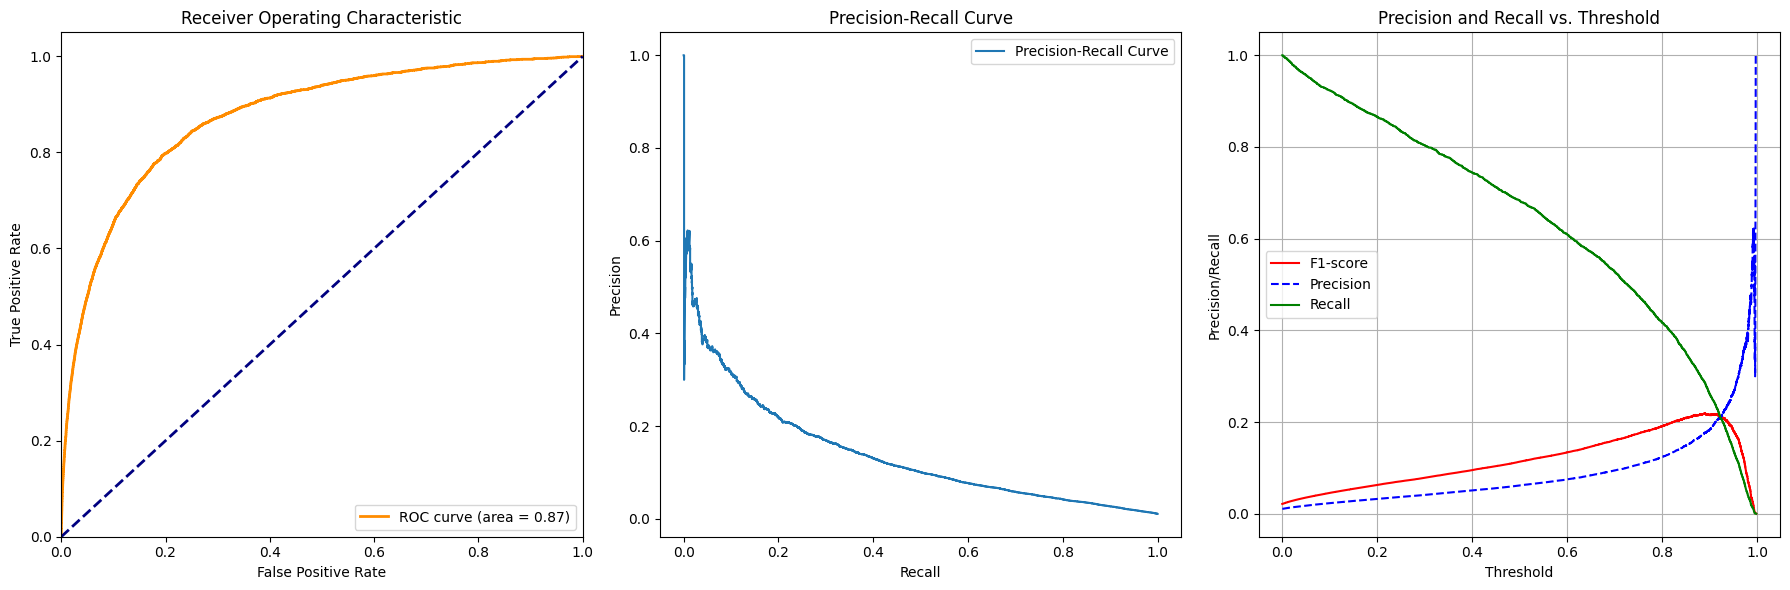

In [8]:
plotter = PerformancePlotter()
plotter.plot_metrics(y_test, y_proba) 

## SHAP

In fraud detection, you may want to prioritize recall (capturing as many fraud cases as possible), even if it comes at the expense of lower precision. The business cost of missing fraud might be higher than the cost of false positives.

In [9]:
import shap

# SHAP Values
# Create a SHAP explainer for the trained XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Ensure base_values are included in the Explanation object
shap_explanation = shap.Explanation(values=shap_values,
                                    base_values=explainer.expected_value,  # This might need adjustment based on your specific model setup
                                    data=X_test,
                                    feature_names=X_test.columns)

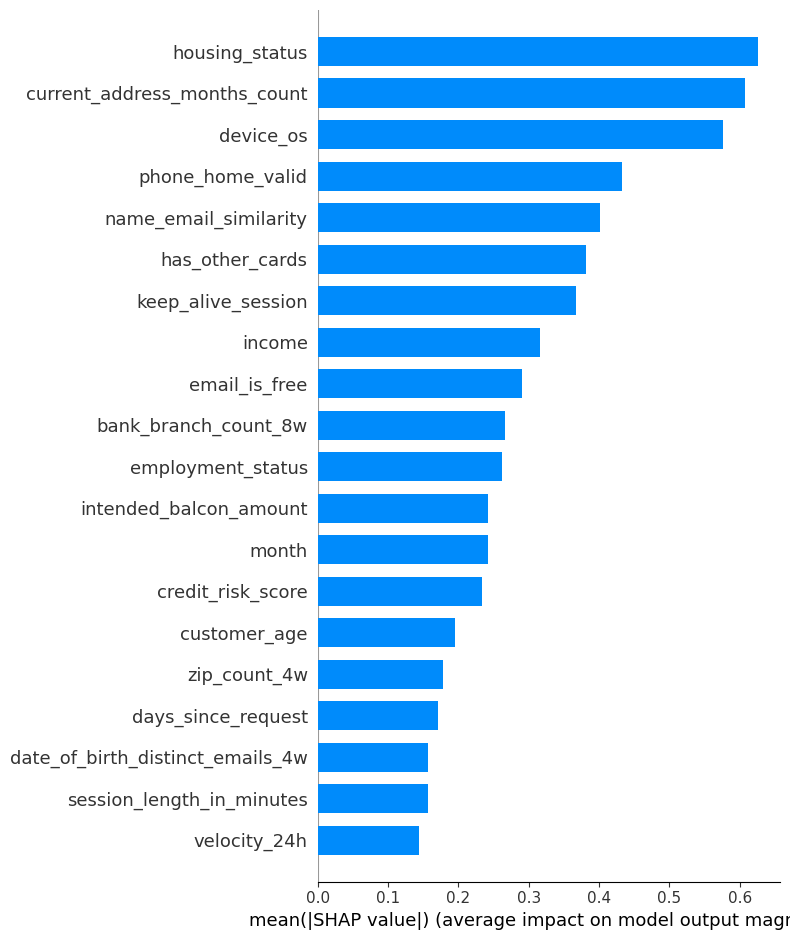

In [10]:
# Visualize global feature importance with SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

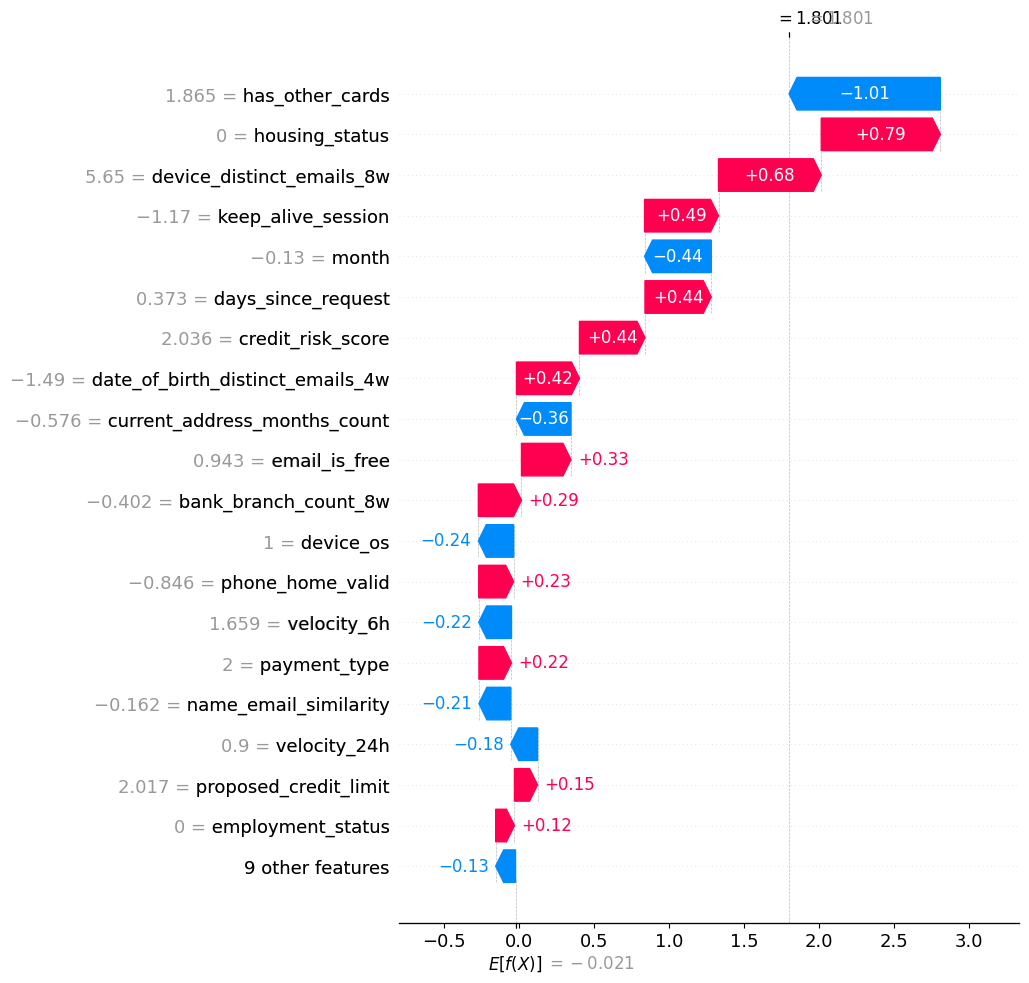

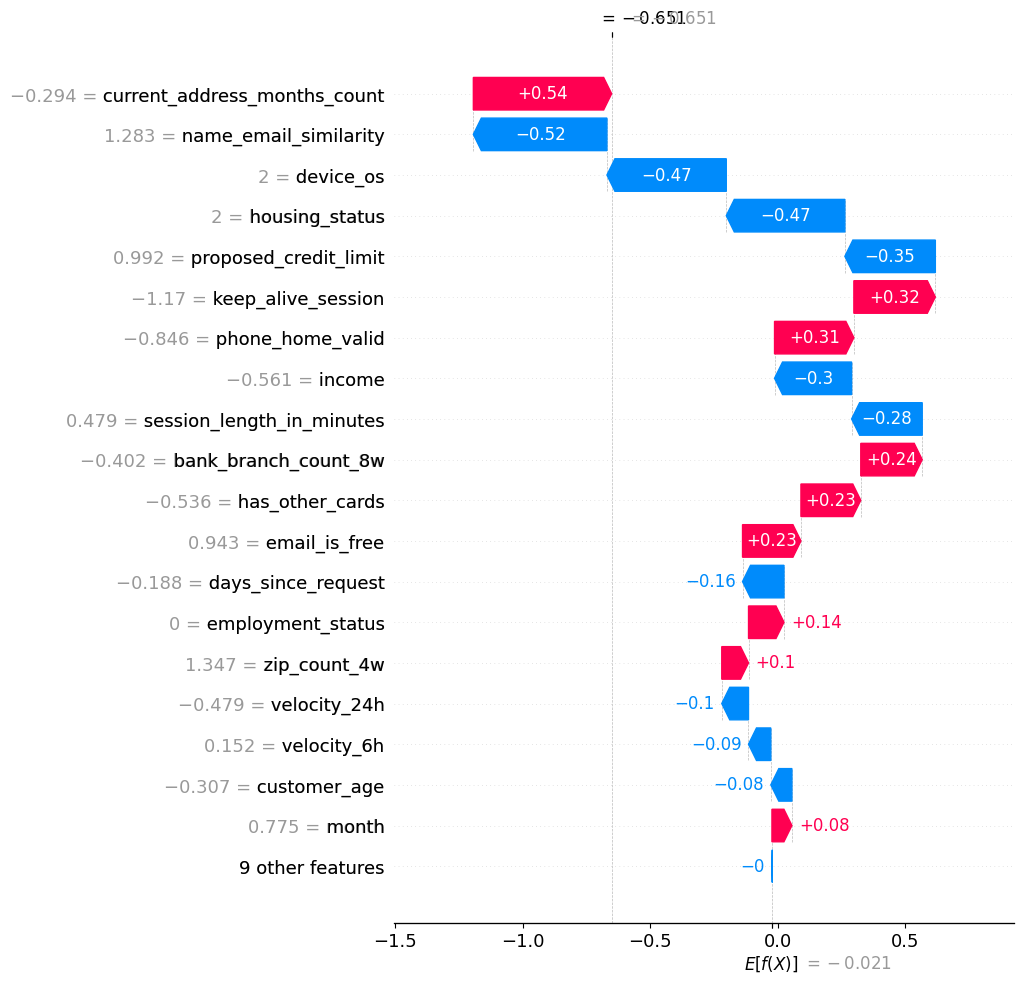

In [11]:
# Identify the true positives (where predicted class is 1 and actual class is 1)
true_positives = np.where((y_pred == 1) & (y_test == 1))[0]
true_negatives = np.where((y_pred == 0) & (y_test == 0))[0]

# First true positive case
if len(true_positives) > 0:
    i_pos = true_positives[0]
    shap.plots.waterfall(shap_explanation[i_pos], max_display=20)
    plt.show()

# First true negative case
if len(true_negatives) > 0:
    i_neg = true_negatives[0]
    shap.plots.waterfall(shap_explanation[i_neg], max_display=20)
    plt.show()

In a SHAP waterfall plot, E[f(X)] represents the expected value of the model's output over the input data distribution. It's the average prediction of the model without specific information about an instance, serving as a baseline or starting point. In fraud detection, this value helps to determine how far an individual prediction deviates from this average, indicating the likelihood of fraud for that particular case. In this case, E[f(X)]=−0.025, indicating the neutral baseline from which the model calculates deviations due to specific features.

In the SHAP waterfall plot for fraud detection, red bars indicate features that contribute to a higher likelihood of fraudulent activity. Here's how key features influence the model’s prediction towards fraud:

- Housing Status (BA): Contribution: +0.82. Certain housing statuses may correlate with fraudulent behaviors, indicating patterns observed in past fraud cases.
- Name Email Similarity: Contribution: +0.59. High similarity could suggest crafted credentials typical in fraudulent applications.
- Device OS (Windows): Contribution: +0.59. This may indicate a preference or vulnerability exploited by fraudsters using this OS.
- Bank Branch Count (8w): Contribution: +0.35. High interaction frequency might be a tactic to establish credibility before committing fraud.
- Keep Alive Session: Contribution: +0.32. Longer sessions may relate to fraudsters setting up detailed and deceptive profiles or transactions.
- These features are key indicators that drive the model’s assessment towards identifying a transaction or profile as fraudulent.

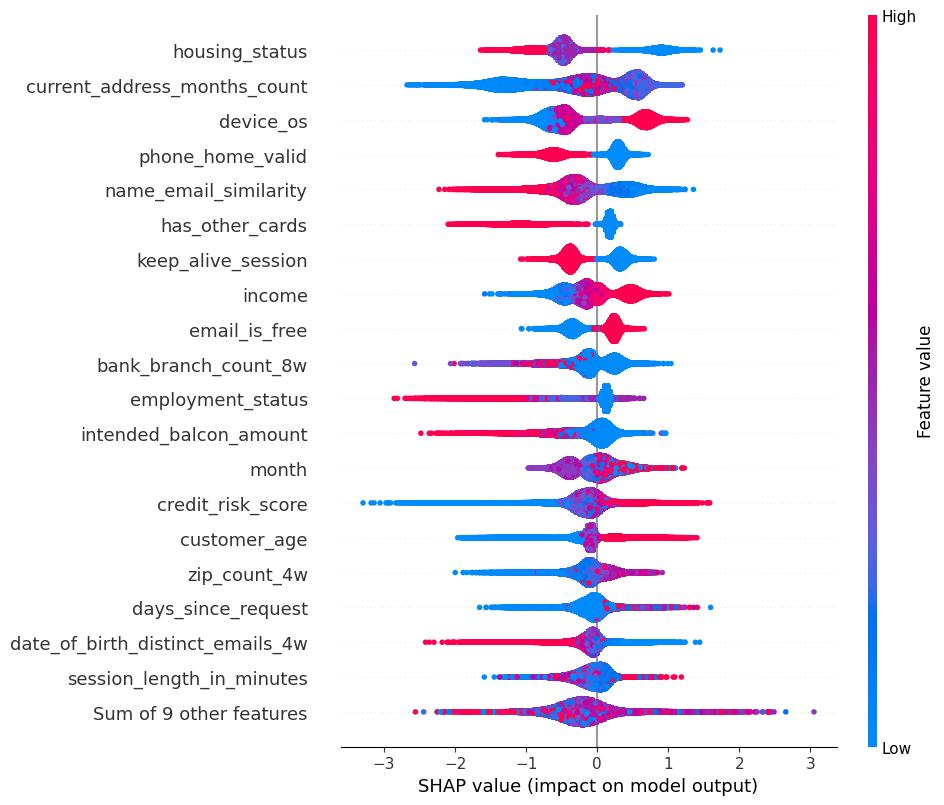

In [12]:
shap.plots.beeswarm(shap_explanation, max_display=20)

Here's a concise explanation of the SHAP beeswarm plot:

- Feature Impact: Each point shows how much a feature changes the model's prediction for each instance. Red points increase the prediction; blue points decrease it.
- Feature Arrangement: Features are vertically listed by their overall impact on the model, with the most influential features at the top.
- Gray Points: Indicate features with minimal or highly variable impacts on the model’s output.
- Insights: This plot helps identify which features are key drivers of predictions and reveals the complexity of feature interactions within the model.

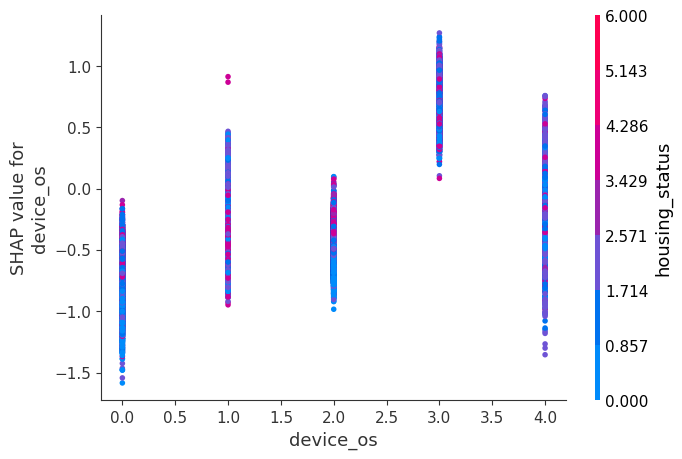

In [13]:
shap.dependence_plot("device_os", shap_values, X_test)